In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms
from torchvision.transforms import v2
import numpy as np
# import PIL

In [2]:
torchvision.__version__

'0.16.0'

## Import data

In [3]:
folder="./dataset"
# transform = transforms.Compose([transforms.ToTensor()])
# transform = transforms.Compose([transforms.Resize((224, 224))])
data_train_val=torchvision.datasets.FashionMNIST(root=folder,train=True,download=True,transform=None)
data_test=torchvision.datasets.FashionMNIST(root=folder,train=False,download=True,transform=None)
classes=data_test.classes

In [4]:
# data_train_val.data[:2000].shape
data_test.data.shape
# type(data_train_val.data)
# data_test.targets.shape

torch.Size([10000, 28, 28])

### 1. Data Preparation (10 points)
- (a) Data cleansing and transformation (5 points)

In [5]:
class dataset(torch.utils.data.Dataset):
    def __init__(self, inputs, targets, trans=None):
        self.x = inputs
        self.y = targets
        self.trans=trans

    def __len__(self):
        return self.x.size()[0]

    def __getitem__(self, idx):

        if self.trans == None:
            # print("no trans")
            return ( self.x[idx], self.y[idx])
        else:
            # print("trans")
            return ( self.trans(self.x[idx]), self.y[idx]) 

def ds_trans(ds_input,trans_flag):
    data_input=ds_input.data.clone().detach()
    labels_input=ds_input.targets
    if data_input.ndim <= 3:
        transform_train_val = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((64, 64)), 
            transforms.RandomHorizontalFlip(0.5),
            transforms.RandomAffine(degrees=(0,3), translate=(0,0.05), scale=None, shear=(0,0.05)),
            transforms.RandomResizedCrop(size=(64,64),scale=(0.9,1.0),ratio=(0.9,1.1)),
            transforms.ToTensor(),
            # transforms.Normalize(0.5, 0.5)
        ])
        transform_test = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((64, 64)), 
            transforms.ToTensor(),
            #  transforms.Normalize(0.5, 0.5)
        ])
    elif data_input.ndim == 4:
        # Should not come here
        print("WRONG!")

    if torch.isnan(data_input).any():
        print("have NaN or Inf")
    data_input = data_input[:,None,:,:]
    print(data_input.shape)
    
    if trans_flag==1:
        flag_ds_new = dataset(data_input, labels_input, trans=transform_train_val)
    elif trans_flag==2:
        flag_ds_new = dataset(data_input, labels_input, trans=transform_test)
    else:
        flag_ds_new = dataset(data_input, labels_input, trans=None)
    return (flag_ds_new)
    

In [6]:
ds_processed_train_val=ds_trans(ds_input=data_train_val,trans_flag=1)
ds_processed_test=ds_trans(ds_input=data_test,trans_flag=2)
# ds_processed.x.shape

torch.Size([60000, 1, 28, 28])
torch.Size([10000, 1, 28, 28])


- (b) Data splitting (i.e., training, validation, and test splits) (5 points)

In [7]:
from torch.utils.data.sampler import SubsetRandomSampler

random_seed=22
indices = list(range(data_train_val.targets.shape[0]))
np.random.seed(random_seed)
np.random.shuffle(indices)

indices_train=indices[:50000]
indices_val=indices[50000:]

ds_processed_train_sampler=SubsetRandomSampler(indices_train)
ds_processed_val_sampler=SubsetRandomSampler(indices_val)

# batch_size=64
batch_size=256
num_workers=10
loader_train = torch.utils.data.DataLoader(ds_processed_train_val, batch_size=batch_size,sampler=ds_processed_train_sampler,
                                            num_workers=num_workers)
loader_val = torch.utils.data.DataLoader(ds_processed_train_val, batch_size=batch_size,sampler=ds_processed_val_sampler,
                                            num_workers=num_workers)
loader_test = torch.utils.data.DataLoader(ds_processed_test, batch_size=batch_size,
                                          shuffle=True, num_workers=num_workers)

In [8]:
for batch_idx, (inputs, targets) in enumerate(loader_train):
    break
print(inputs.shape)
print(targets.shape)

torch.Size([256, 1, 64, 64])
torch.Size([256])


## 2. Exploratory Data Analysis (EDA) (10 points)
- (a) Descriptive statistics (e.g., class distributions, data statistics) (5 points)

- (b) Data visualization (e.g., plot examples from classes, dimensionality reduction approach to show data) (5 points)

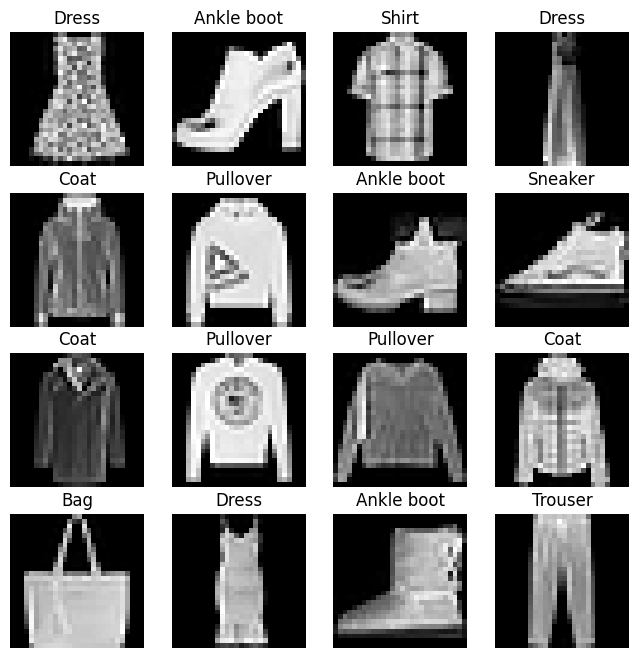

In [9]:
import matplotlib.pyplot as plt
figure = plt.figure(figsize = (8,8))
cols, rows = 4, 4
ids=torch.randint(len(data_test), size = (cols*rows,))
for i in range (1, cols*rows + 1):
    image, label = data_test[ids[i-1].item()]
    figure.add_subplot(rows, cols, i)
    plt.title(classes[label])
    plt.axis('off')
    # plt.imshow(image.squeeze(), cmap='gray')
    plt.imshow(image, cmap='gray')
    # plt.imshow(image.squeeze())
plt.show()

## 3. Model Selection (20 points)
- (a) Algorithm selection: Justification for choosing specific data mining algorithm (e.g., decision trees, KNN, neural networks, etc.). (5 points)

In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def trainloop (dataloader, model, loss_fn, optimizer,device):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X,y) in enumerate(dataloader):
        X,y=X.to(device),y.to(device)
        
        # Compute the error rate
        prediction = model(X)
        loss = loss_fn(prediction, y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch*len(X)
            print(f'loss:{loss:>7f} [{current:>5d}/{size:>5d}]')
            
def evaluate (dataloader, model, loss_fn,device):
    # size = len(dataloader.dataset)
    size = len(dataloader.sampler)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    Y_pred=[]
    Y_true=[]
    with torch.no_grad():
        for X,y in dataloader:
            X,y = X.to(device),y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            Y_pred.append(pred.argmax(1).cpu().numpy())
            Y_true.append(y.cpu().numpy())
    test_loss /= num_batches
    correct /= size
    print(f'Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n')
    accuracy=100*correct
    Y_pred=np.concatenate(Y_pred)
    Y_true=np.concatenate(Y_true)
    accuracy2=accuracy_score(Y_true,Y_pred)
    # print(f'Accuracy2: {(accuracy2*100):>0.1f}')
    precision = precision_score(Y_true, Y_pred, average='macro')
    recall = recall_score(Y_true, Y_pred, average='macro')
    f1 = f1_score(Y_true, Y_pred, average='macro')
    cm = confusion_matrix(Y_true, Y_pred)
    print("accuracy, precision, recall, f1, test_loss:")
    print(accuracy, precision, recall, f1, test_loss)
    return [accuracy, precision, recall, f1, test_loss], cm

- (b) Model building: Developing and tuning selected model (e.g., hyperparameter tuning) (10 points)
- (c) Model evaluation: Proper evaluation metrics (e.g., accuracy, precision, recall, F1-score) and qualitative analysis (e.g., confusion matrices) for classification on test set. (5 points)

In [11]:
import torchvision
# define function for building, training, and testing the model.
def build_train_model(loader_train,loader_val,loader_test,learning_rate,id_optimizer):
    device ='cuda' if torch.cuda.is_available else 'cpu'
    print(f'Using {device} device')
    # model = torch.hub.load('pytorch/vision:v0.10.0', 'wide_resnet50_2', pretrained=True)
    # model=torchvision.models.vgg11()
    # model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=False)
    # model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', weights='DenseNet121_Weights.IMAGENET1K_V1')
    model=torchvision.models.squeezenet1_0(weights='SqueezeNet1_0_Weights.IMAGENET1K_V1')
    
    # model
    # model.conv1=torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    # model.features[0]=torch.nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) # vgg
    # model.features[0]=torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3)) # densenet121
    model.features[0]=torch.nn.Conv2d(1, 96, kernel_size=(7, 7), stride=(2, 2)) # SqueezeNet

    model=model.to(device)
    # model

    # Define hyperparameters
    # learning_rate = 1e-4

    # Define epochs
    epochs = 50

    # Loss Function
    loss_fn = nn.CrossEntropyLoss()
    # loss_fn = nn.MSELoss(reduction='sum')

    # Optimizer
    if id_optimizer==0:
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif id_optimizer==1:
        optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
    elif id_optimizer==2:
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    

    for i in range(epochs):
        print(f"Epoch {i+1}")
        # print(f"Epoch {i+1}\n-------------------------------")
        trainloop(loader_train, model, loss_fn, optimizer,device)

        if i%25==0:
            print("Training Dataset Error:")
            evaluate(loader_train, model, loss_fn,device)
            print("Validation Dataset Error:");
            evaluate(loader_val, model, loss_fn,device)
            print("Test Dataset Error:");
            evaluate(loader_test, model, loss_fn,device)

    
    # Acc=np.zeros(3)
    # Loss=np.zeros(3)
    # print("Training Dataset Error:")
    # Acc[0],Loss[0]=evaluate(loader_train, model, loss_fn,device)
    # print("Validation Dataset Error:");
    # Acc[1],Loss[1]=evaluate(loader_val, model, loss_fn,device)
    # print("Test Dataset Error:");
    # Acc[2],Loss[2]=evaluate(loader_test, model, loss_fn,device)

    print("Training Dataset Error:")
    result_train,cm_train=evaluate(loader_train, model, loss_fn,device)
    print("Validation Dataset Error:");
    result_val,cm_val=evaluate(loader_val, model, loss_fn,device)
    print("Test Dataset Error:");
    result_test,cm_test=evaluate(loader_test, model, loss_fn,device)

    results=[result_train,result_val,result_test]

    return results,cm_val

In [12]:
# define function for 6-fold cross validation to return training, validation, and testing dataset.
def split_6_fold(index,ds_processed_train_val,ds_processed_test,indices):
    N=ds_processed_train_val.y.shape[0]
    nsub=int(N/6)
    # indices_train=indices[:50000]
    indices_train=[indices[i] for i in range(N) if i <index*nsub or i >=(index+1)*nsub]
    indices_val=indices[index*nsub:(index+1)*nsub]

    ds_processed_train_sampler=SubsetRandomSampler(indices_train)
    ds_processed_val_sampler=SubsetRandomSampler(indices_val)

    # batch_size=64
    batch_size=256
    num_workers=6
    loader_train = torch.utils.data.DataLoader(ds_processed_train_val, batch_size=batch_size,sampler=ds_processed_train_sampler,
                                                num_workers=num_workers)
    loader_val = torch.utils.data.DataLoader(ds_processed_train_val, batch_size=batch_size,sampler=ds_processed_val_sampler,
                                                num_workers=num_workers)
    loader_test = torch.utils.data.DataLoader(ds_processed_test, batch_size=batch_size,
                                            shuffle=True, num_workers=num_workers)
    return  loader_train,loader_val,loader_test

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# define function for cross validation with given hyperparameters or optimizer selection.
def one_iteration(learning_rate, id_optimizer,indices):
    # learning_rate=1e-4
    # id_optimizer=0
    ACC=[]
    LOSS=[]
    Results=[]
    CM_val=[]
    for i in range(1):
        print(f"Fold {i}\n-------------------------------")
        loader_train,loader_val,loader_test=split_6_fold(i,ds_processed_train_val,ds_processed_test,indices)
        results,cm_val=build_train_model(loader_train,loader_val,loader_test,learning_rate,id_optimizer)
        results=np.array(results)
        Results.append(results)
        CM_val.append(cm_val)
        torch.cuda.empty_cache() # test
    Results=np.array(Results) # dim0: i from 0-5; dim1: train, val, test; dim2: acc, precision, recall, f1 score, loss
    Results_ave=np.mean(Results,0) #dim0: train, val, test; dim1: acc, precision, recall, f1 score, loss
    try:
        CM_val_ave=np.mean(CM_val,0)
        CM_val_ave_percent=CM_val_ave/np.sum(CM_val_ave,
                                             axis=1,keepdims=True)

        # print("np.sum(CM_val_ave)=",np.sum(CM_val_ave)) # close to 10000. Wrong
        # ACC=Results_ave[:,0]
        # LOSS=Results_ave[:,4]
        # print("ACC:\nAve: ",np.mean(ACC,0),"std: ",np.std(ACC,0))
        # print("LOSS:\nAve: ",np.mean(LOSS,0),"std: ",np.std(LOSS,0))
        print("Results_ave: \nacc, precision, recall, f1 score, loss")
        print(Results_ave)
        print("Confusion Matrix: \n",CM_val_ave_percent)
        classes_id=['0','1','2','3','4','5','6','7','8','9']
        # print(classes)
        disp = ConfusionMatrixDisplay(confusion_matrix=np.round(CM_val_ave_percent,2),
                                display_labels=classes_id)
        disp.plot()
        plt.show()
    except:
        print("Failed to plot.")

    return Results_ave

id_optimizer: 0	learning_rate: 0.001 
-----------------------------------------------------------
Fold 0
-------------------------------
Using cuda device
Epoch 1
loss:14.763957 [    0/60000]
loss:0.706811 [25600/60000]
Training Dataset Error:
Accuracy: 80.4%, Avg loss: 0.499955 

accuracy, precision, recall, f1, test_loss:
80.36999999999999 0.7994109936941487 0.8023278449116089 0.7831125286886652 0.49995532753516214
Validation Dataset Error:
Accuracy: 79.5%, Avg loss: 0.511172 

accuracy, precision, recall, f1, test_loss:
79.47 0.7988340902097678 0.8016142552446845 0.7817099048595556 0.5111721754074097
Test Dataset Error:
Accuracy: 80.3%, Avg loss: 0.517343 

accuracy, precision, recall, f1, test_loss:
80.28999999999999 0.802455029764569 0.8029 0.7825744078178689 0.5173427581787109
Epoch 2
loss:0.511933 [    0/60000]
loss:0.433361 [25600/60000]
Epoch 3
loss:0.542304 [    0/60000]
loss:0.384783 [25600/60000]
Epoch 4
loss:0.449508 [    0/60000]
loss:0.344179 [25600/60000]
Epoch 5
loss:0

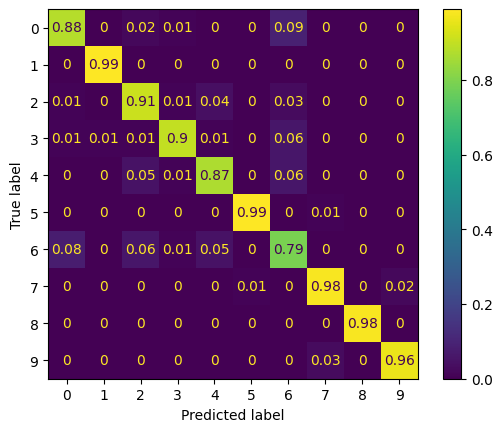

####################################################


In [14]:
# Use 6-fold validation to search best learning rate and optimizer.
random_seed=22
indices = list(range(ds_processed_train_val.y.shape[0]))
np.random.seed(random_seed)
np.random.shuffle(indices)
Results_all=[]
# for id_optimizer in [0,1]:
for id_optimizer in [0]:
    # for learning_rate in [1e-3,1e-4,1e-5]:
    for learning_rate in [1e-3]:
        print(f"id_optimizer: {id_optimizer}\tlearning_rate: {learning_rate} \n-----------------------------------------------------------")
        Results_ave= one_iteration(learning_rate,id_optimizer,indices)
        Results_all.append([id_optimizer, learning_rate, Results_ave])
        print('####################################################')


In [15]:
Results_all

[[0,
  0.001,
  array([[94.588     ,  0.94619263,  0.94560656,  0.94568772,  0.14431602],
         [92.33      ,  0.92651303,  0.92509943,  0.92561379,  0.23182441],
         [92.42      ,  0.92478942,  0.9242    ,  0.92420012,  0.22483893]])]]

## Retrain model with the best learning rate and optimizer
We retrain the model because in the cross validation we don't use the validation dataset for training. For the purpose of the best usage of dataset, we use all 60000 dataset in previous training and validation to train the model, and then estimate the final performance on the testing dataset.

In [16]:
def build_train_best_model(loader_train,loader_test,learning_rate,id_optimizer):
    device ='cuda' if torch.cuda.is_available else 'cpu'
    print(f'Using {device} device')
    # model = torch.hub.load('pytorch/vision:v0.10.0', 'wide_resnet50_2', pretrained=True)
    # model=torchvision.models.vgg11()
    # model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=False)
    # model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', weights='DenseNet121_Weights.IMAGENET1K_V1')
    model=torchvision.models.squeezenet1_0(weights='SqueezeNet1_0_Weights.IMAGENET1K_V1')
    
    # model
    # model.conv1=torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    # model.features[0]=torch.nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) # vgg
    # model.features[0]=torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3)) # densenet121
    model.features[0]=torch.nn.Conv2d(1, 96, kernel_size=(7, 7), stride=(2, 2)) # SqueezeNet

    model=model.to(device)
    # model

    # Define hyperparameters
    # learning_rate = 1e-4
    epochs = 100

    # Loss Function
    loss_fn = nn.CrossEntropyLoss()
    # loss_fn = nn.MSELoss(reduction='sum')

    # Optimizer
    if id_optimizer==0:
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif id_optimizer==1:
        optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
    elif id_optimizer==2:
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    

    for i in range(epochs):
        print(f"Epoch {i+1}")
        # print(f"Epoch {i+1}\n-------------------------------")
        trainloop(loader_train, model, loss_fn, optimizer,device)
        # trainloop(loader_test, model, loss_fn, optimizer,device) # for testing

        if i%25==0:
            print("Training Dataset Error:")
            evaluate(loader_train, model, loss_fn,device)
            print("Test Dataset Error:");
            evaluate(loader_test, model, loss_fn,device)

    print("Training Dataset Error:")
    result_train,cm_train=evaluate(loader_train, model, loss_fn,device)
    print("Testing Dataset Error:");
    result_test,cm_test=evaluate(loader_test, model, loss_fn,device)

    results=[result_train,result_test]

    # return results,cm_val
    return model

In [17]:
loader_train_all=torch.utils.data.DataLoader(ds_processed_train_val, batch_size=batch_size,
                                          shuffle=True, num_workers=num_workers)
learning_rate=1e-3
id_optimizer=0
model_best=build_train_best_model(loader_train_all,loader_test,learning_rate,id_optimizer)



Using cuda device
Epoch 1


loss:15.624755 [    0/60000]
loss:0.696481 [25600/60000]
loss:0.481912 [51200/60000]
Training Dataset Error:
Accuracy: 78.5%, Avg loss: 0.532027 

accuracy, precision, recall, f1, test_loss:
78.53999999999999 0.8008632078256094 0.7854 0.7795439274756177 0.5320268892227336
Test Dataset Error:
Accuracy: 77.7%, Avg loss: 0.545096 

accuracy, precision, recall, f1, test_loss:
77.68 0.802414317809901 0.7767999999999999 0.7687083793332202 0.5450963228940964
Epoch 2
loss:0.618677 [    0/60000]
loss:0.493069 [25600/60000]
loss:0.460256 [51200/60000]
Epoch 3
loss:0.405280 [    0/60000]
loss:0.430581 [25600/60000]
loss:0.434212 [51200/60000]
Epoch 4
loss:0.509196 [    0/60000]
loss:0.342295 [25600/60000]
loss:0.321080 [51200/60000]
Epoch 5
loss:0.375210 [    0/60000]
loss:0.351266 [25600/60000]
loss:0.210519 [51200/60000]
Epoch 6
loss:0.279101 [    0/60000]
loss:0.378389 [25600/60000]
loss:0.298394 [51200/60000]
Epoch 7
loss:0.269324 [    0/60000]
loss:0.300257 [25600/60000]
loss:0.298148 [51200

## 6. Interpretability (10 point)
- (a) Model interpretablity: Demonstrating an understanding of how the model makes predictions (e.g., feature importance). (5 points)
Using Grad-cam method to analyze the interpretablity of the nerual network.

In [18]:
# model_best.features[-1]
# model_best.features[12]
t1,t2=ds_processed_test[852]
t2.item()

5

8481
label_pred:  2
label_treu:  2


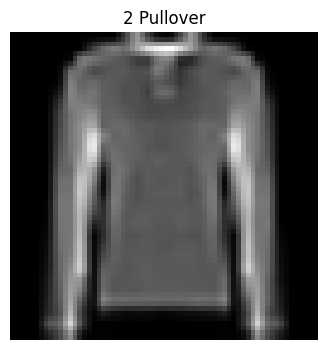

In [114]:
import matplotlib.pyplot as plt
figure = plt.figure(figsize = (4,4))
cols, rows = 1, 1
ids=torch.randint(len(data_test), size = (cols*rows,))

# transform_test = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.ToPILImage(),
#     transforms.Resize((64, 64)), 
#     transforms.ToTensor(),
#     transforms.Normalize(0.5, 0.5)
# ])
print(ids.item())
# image, label = data_test[ids[i-1].item()]
# image_tensor=transform_test(image)

image_tensor,label_tensor=ds_processed_test[ids.item()]
image=transforms.ToPILImage()(image_tensor[0,:,:])
# image_tensor.shape
image_tensor=image_tensor[None,:,:,:]
# label_tensor=torch.tensor([label])
# image_tensor[0,0,30,:]
label=label_tensor.item()

model=model_best
model.eval()
# model.train()
device='cuda'
X,y = image_tensor.to(device),label_tensor.to(device)
# X=X[None,:,:,:]
pred = model(X)
label_pred=pred.argmax(1).item()
print("label_pred: ",label_pred)
print("label_treu: ", label)

figure.add_subplot(rows, cols, 1)
plt.title(str(label)+" "+classes[label])
plt.axis('off')
plt.imshow(image, cmap='gray')
# plt.imshow(image.squeeze())
plt.show()

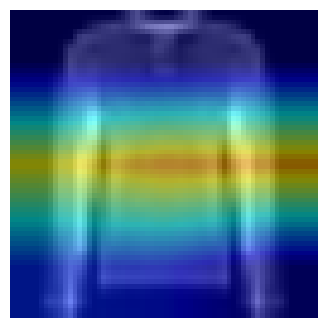

In [122]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50

import requests
import torchvision
from PIL import Image
import numpy as np

# image_url = "https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/both.png"
# image = np.array(Image.open(requests.get(image_url, stream=True).raw))
# image=image[:,:,[0,0,0]]
transform_1 = transforms.Compose([
    transforms.Resize((64, 64)), 
])
image_resize=transform_1(image)
# torch.max(tensor_input)
image_ts=np.array(image_resize)
image_ts2=image_ts[:,:,None]
# image_ts2=image_ts2[:,:,[0,0,0]]

image_float_np = np.float32(image_ts2) / 255
# transform = torchvision.transforms.Compose([
#     torchvision.transforms.ToTensor(),
# ])

# input_tensor = transform(image_ts2)
input_tensor=X
# input_tensor=input_tensor[None,:,:,:]

# model = resnet50(pretrained=True)
# target_layers = [model.layer4[-1]]
# model=model_best
target_layers=[model.features[-1]]
# target_layers=[model.classifier[2]]
# target_layers=[]
# input_tensor = # Create an input tensor image for your model..
# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)

id_target=2
targets = [ClassifierOutputTarget(id_target)]
# targets=[ClassifierOutputTarget(label_pred)]
# targets=None

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets,aug_smooth=True, eigen_smooth=True)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(image_float_np, grayscale_cam, use_rgb=True)
img_vis=Image.fromarray(visualization)

# figure.add_subplot(rows, cols, 1)
fig=plt.figure(figsize=(4,4))
# plt.title(str(label)+" "+classes[label])
plt.axis('off')
plt.imshow(img_vis)
# ax = plt.Axes(fig, [0., 0., 1., 1.])
# ax.set_axis_off()
# fig.add_axes(ax)
plt.savefig("../img/"+str(label)+"_"+classes[label]+"_"+str(id_target)+".png")
plt.show()

In [56]:
grayscale_cam.shape

(64, 64)

In [113]:
# from pytorch_grad_cam.metrics.road import ROADMostRelevantFirst, ROADLeastRelevantFirst
# cam_metric = ROADMostRelevantFirst(percentile=75)
# scores, perturbation_visualizations = cam_metric(input_tensor, 
#   grayscale_cam, targets, model, return_visualization=True)

# input_tensors=input_tensor[[0,0],:,:,:]
# grayscale_cams=grayscale_cam[None,:,:]
# # grayscale_cams=grayscale_cam[[0,0],:,:]
# targets2=[ClassifierOutputTarget(8),ClassifierOutputTarget(8)]
# from pytorch_grad_cam.metrics.road import ROADMostRelevantFirstAverage,ROADLeastRelevantFirstAverage,ROADCombined
# cam_metric = ROADCombined(percentiles=[20, 40, 60, 80])
# scores = cam_metric(input_tensor, grayscale_cam, targets2, model)
